In [1]:
! nvidia-smi

Tue May  7 17:11:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import time
import pandas as pd
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

In [5]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl").to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [9]:
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip

--2024-05-07 18:00:55--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... failed: Connection timed out.
Retrying.

--2024-05-07 18:03:06--  (try: 2)  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... failed: Connection timed out.
Retrying.

--2024-05-07 18:05:18--  (try: 3)  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... failed: Connection timed out.
Retrying.

--2024-05-07 18:07:30--  (try: 4)  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... ^C


In [10]:
!unzip snli_1.0.zip

Archive:  snli_1.0.zip
   creating: snli_1.0/
  inflating: snli_1.0/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/snli_1.0/
  inflating: __MACOSX/snli_1.0/._.DS_Store  
 extracting: snli_1.0/Icon           
  inflating: __MACOSX/snli_1.0/._Icon  
  inflating: snli_1.0/README.txt     
  inflating: __MACOSX/snli_1.0/._README.txt  
  inflating: snli_1.0/snli_1.0_dev.jsonl  
  inflating: snli_1.0/snli_1.0_dev.txt  
  inflating: snli_1.0/snli_1.0_test.jsonl  
  inflating: snli_1.0/snli_1.0_test.txt  
  inflating: snli_1.0/snli_1.0_train.jsonl  
  inflating: snli_1.0/snli_1.0_train.txt  
  inflating: __MACOSX/._snli_1.0     


In [11]:
df_test = pd.read_csv("snli_1.0/snli_1.0_test.txt", sep="\t")

In [12]:
df_test.drop(df_test.columns.difference(['gold_label','sentence1', 'sentence2']), axis=1, inplace=True) ## to drop the columns

In [13]:
df_test = df_test[df_test['gold_label'] != '-'].reset_index(drop=True)

In [14]:
df_test[:10]

,gold_label,sentence1,sentence2
0,neutral,This church choir sings to the masses as they ...,The church has cracks in the ceiling.
1,entailment,This church choir sings to the masses as they ...,The church is filled with song.
2,contradiction,This church choir sings to the masses as they ...,A choir singing at a baseball game.
3,neutral,"A woman with a green headscarf, blue shirt and...",The woman is young.
4,entailment,"A woman with a green headscarf, blue shirt and...",The woman is very happy.
5,contradiction,"A woman with a green headscarf, blue shirt and...",The woman has been shot.
6,entailment,An old man with a package poses in front of an...,A man poses in front of an ad.
7,neutral,An old man with a package poses in front of an...,A man poses in front of an ad for beer.
8,contradiction,An old man with a package poses in front of an...,A man walks by an ad.
9,neutral,A statue at a museum that no seems to be looki...,The statue is offensive and people are mad tha...


In [15]:
df_test.to_csv('test.txt', sep='\t', index=False)


In [16]:
gold_labels = pd.read_csv("test.txt", sep="\t", usecols=["gold_label"])

In [18]:
# save the gold_labels in a txt file

gold_labels.to_csv('gold_labels.txt', index=False, header=False)

In [19]:
#convert these gold_labels.txt file into a list such that entailement=1, contradiction=2 and neutral=3

test_gold_labels_list = []
with open('gold_labels.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line == 'entailment':
            test_gold_labels_list.append(1)
        elif line == 'contradiction':
            test_gold_labels_list.append(2)
        elif line == 'neutral':
            test_gold_labels_list.append(3)

In [20]:
df_test.groupby('gold_label').count()

,sentence1,sentence2
gold_label,,
contradiction,3237,3237
entailment,3368,3368
neutral,3219,3219


In [21]:
prompt = "What is the relationship of the second sentence with the first sentence?\nSENTENCE 1: {sentence1} \nSENTENCE 2: {sentence2} \nOPTIONS:\n- entailment  \n- contradiction \n- neutral. \n Answer in single word only."

In [22]:
sentences = []
for i in range(len(df_test['sentence1'])):  # Assuming all columns are the same length
    sentences.append([df_test['sentence1'][i], df_test['sentence2'][i], df_test['gold_label'][i]])

In [23]:
import re
input_text = []
for sentence1, sentence2, label in sentences:
    prompt_new = re.sub('{sentence1}', sentence1, prompt)
    prompt_new = re.sub('{sentence2}', sentence2, prompt_new)
    input_text.append(prompt_new)

In [24]:
sentences[:10]

[['This church choir sings to the masses as they sing joyous songs from the book at a church.',
  'The church has cracks in the ceiling.',
  'neutral'],
 ['This church choir sings to the masses as they sing joyous songs from the book at a church.',
  'The church is filled with song.',
  'entailment'],
 ['This church choir sings to the masses as they sing joyous songs from the book at a church.',
  'A choir singing at a baseball game.',
  'contradiction'],
 ['A woman with a green headscarf, blue shirt and a very big grin.',
  'The woman is young.',
  'neutral'],
 ['A woman with a green headscarf, blue shirt and a very big grin.',
  'The woman is very happy.',
  'entailment'],
 ['A woman with a green headscarf, blue shirt and a very big grin.',
  'The woman has been shot.',
  'contradiction'],
 ['An old man with a package poses in front of an advertisement.',
  'A man poses in front of an ad.',
  'entailment'],
 ['An old man with a package poses in front of an advertisement.',
  'A man p

In [25]:
input_text[:10]

['What is the relationship of the second sentence with the first sentence?\nSENTENCE 1: This church choir sings to the masses as they sing joyous songs from the book at a church. \nSENTENCE 2: The church has cracks in the ceiling. \nOPTIONS:\n- entailment  \n- contradiction \n- neutral. \n Answer in single word only.',
 'What is the relationship of the second sentence with the first sentence?\nSENTENCE 1: This church choir sings to the masses as they sing joyous songs from the book at a church. \nSENTENCE 2: The church is filled with song. \nOPTIONS:\n- entailment  \n- contradiction \n- neutral. \n Answer in single word only.',
 'What is the relationship of the second sentence with the first sentence?\nSENTENCE 1: This church choir sings to the masses as they sing joyous songs from the book at a church. \nSENTENCE 2: A choir singing at a baseball game. \nOPTIONS:\n- entailment  \n- contradiction \n- neutral. \n Answer in single word only.',
 'What is the relationship of the second sent

In [26]:
def generate(input_text):
  input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
  output = model.generate(input_ids, max_length=100)
  return tokenizer.decode(output[0], skip_special_tokens=True)

In [27]:
#pass the input_text generated from the above into this function generate and save the output in a .txt file

output_text = []
for text in input_text:
  output_text.append(generate(text))

with open('output.txt', 'w') as f:
  for text in output_text:
    f.write(text + '\n')

In [29]:
output_gold_labels_list = []
with open('output.txt', 'r') as f:
    count=0
    for line in f:
        line = line.strip()
        print(line)
        if line == 'entailment':
            output_gold_labels_list.append(1)
        elif line == 'contradiction':
            output_gold_labels_list.append(2)
        elif line == 'neutral':
            output_gold_labels_list.append(3)
        else:
            count+=1

Streaming output truncated to the last 5000 lines.
neutral
entailment
neutral
contradiction
neutral
contradiction
entailment
contradiction
neutral
entailment
neutral
entailment
contradiction
entailment
contradiction
neutral
contradiction
entailment
neutral
neutral
contradiction
entailment
entailment
contradiction
entailment
contradiction
neutral
entailment
contradiction
neutral
entailment
entailment
neutral
contradiction
entailment
contradiction
entailment
entailment
contradiction
entailment
contradiction
neutral
entailment
entailment
contradiction
entailment
neutral
entailment
contradiction
entailment
contradiction
neutral
entailment
neutral
contradiction
contradiction
contradiction
contradiction
neutral
neutral
neutral
entailment
contradiction
contradiction
entailment
neutral
entailment
contradiction
entailment
neutral
neutral
contradiction
entailment
entailment
contradiction
neutral
entailment
contradiction
entailment
contradiction
neutral
neutral
entailment
contradiction
entailment

In [30]:


from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

accuracy  = accuracy_score(output_gold_labels_list, test_gold_labels_list)
precision = precision_score(output_gold_labels_list, test_gold_labels_list, average='macro')  # Use 'macro' for potential class imbalance
recall    = recall_score(output_gold_labels_list, test_gold_labels_list, average='macro')
f1        = f1_score(output_gold_labels_list, test_gold_labels_list, average='macro')

# Print Results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8663477198697068
Precision: 0.8647580501649245
Recall: 0.8745712942634691
F1-Score: 0.8628808855836175


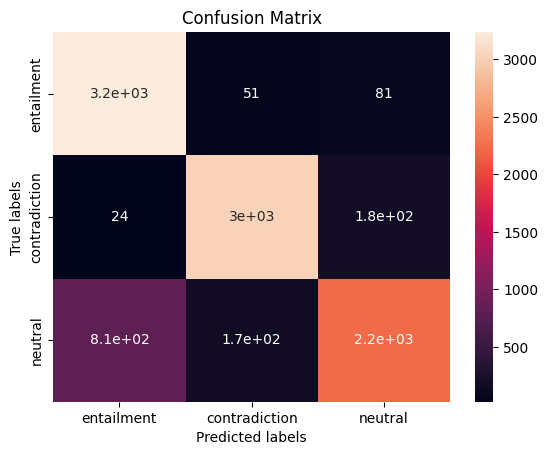

In [31]:
#generate confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(test_gold_labels_list, output_gold_labels_list)

# Configure plot
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)  # Annotate cells with values

# Set labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Set tick labels for x-axis and y-axis
ax.xaxis.set_ticklabels(['entailment', 'contradiction', 'neutral'])
ax.yaxis.set_ticklabels(['entailment', 'contradiction', 'neutral'])

# Display the plot
plt.show()

Normalized Confusion Matrix:
[[0.9608076  0.01514252 0.02404988]
 [0.00741427 0.93728761 0.05529812]
 [0.25132029 0.05250078 0.69617894]]


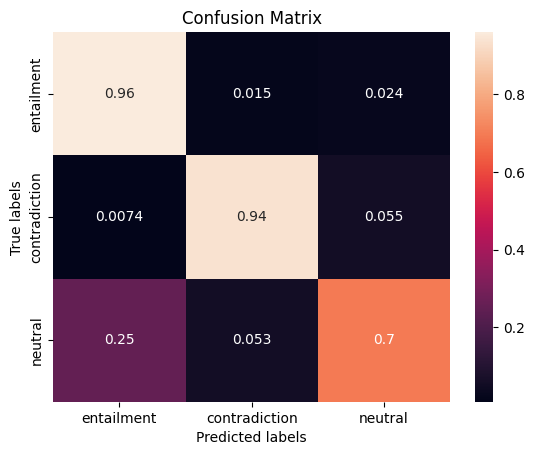

In [34]:

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the normalized confusion matrix
print("Normalized Confusion Matrix:")
print(cm_normalized)
ax = plt.subplot()
sns.heatmap(cm_normalized, annot=True, ax=ax)  # Annotate cells with values

# Set labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Set tick labels for x-axis and y-axis
ax.xaxis.set_ticklabels(['entailment', 'contradiction', 'neutral'])
ax.yaxis.set_ticklabels(['entailment', 'contradiction', 'neutral'])

# Display the plot
plt.show()
